## 🌟 利用朴素贝叶斯分类器实现手写数字识别问题

## 一、朴素贝叶斯分类的原理

### 朴素贝叶斯是一种基于贝叶斯定理和特征条件独立假设的分类算法，它的思想基础是：对于给出的待分类项，求解在此项出现的条件下各个类别出现的概率，哪个最大，就认为此待分类项属于哪个类别。
### 简单而言，对于给定的训练数据朴素贝叶斯先基于特征条件独立假设学习输入和输出的联合概率分布，然后基于此分布对于新的实例，利用贝叶斯定理计算出最大的后验概率。这种方法不会直接学习输入输出的联合概率分布，而是通过学习类的先验概率和类条件概率来完成。朴素的含义即特征条件独立假设，就是说用于分类的特征在类确定的条件下都是条件独立的。
### 朴素贝叶斯分类器是一系列以假设特征之间强（朴素）独立下运用贝叶斯定理为基础的简单概率分类器。它的训练速度往往更快，这种高效率所付出的代价是，朴素贝叶斯模型的泛化能力要比线性分类器稍差。朴素贝叶斯如此高效的原因在于，它通过单独查看每个特征来学习参数，并从每个特征中收集简单的类别统计数据。

### Note:条件独立性假设是：
$$
P(X=x | Y=c_k)=P(X^{(1)}=x^{(1)},\dots,X^{(n)}=x^{(n)} | Y=c_k)=\prod_{j=1}^n P(X^{(j)}=x^{(j)}|Y=c_k)
$$
### 得到后验概率为：
$$
P(Y=c_k | X=x)=\frac{P(Y=c_k) \prod_j P(X^{(j)}=x^{(j)}|Y=c_k)}{\sum_k P(Y=c_k \prod_j P(X^{(j)}=x^{(j)}|Y=c_k)}
$$
### 所以贝叶斯分类器可以表示为：
$$
y=f(x)=argmax_{c_k} \frac{P(Y=c_k) \prod_j P(X^{(j)}=x^{(j)}|Y=c_k)}{\sum_k P(Y=c_k) \prod_j P(X^{(j)}=x^{(j)}|Y=c_k)}
$$
### 因为分母对于所有 $c_k$ 都是相同的，所以：
$$
y=f(x)=argmax_{c_k} P(Y=c_k) \prod_j P(X^{(j)}=x^{(j)}|Y=c_k)
$$

## 朴素贝叶斯法的参数估计
### Step 1：首先计算类先验概率（极大似然估计）：
$$
p(y=c_k)=\frac{1}{N}\sum_{i=1}^{N}I(\tilde{y_i}=c_k),k=1,2,...,K
$$

### Step 2：然后计算类条件概率：
$$
p(x_j=a_{j,l}|y=c_k)=\frac{\sum_{i=1}^N I(x_{i,j}=a_{j,l},\tilde{y_i}=c_k)}{\sum_{i=1}^N I(\tilde{y_i}=c_k)}  
$$
$$
j = 1,2,...,n;l=1,2,...,s_j;k=1,2,...,K
$$

### Step 3：最后给定新的实例，计算其对应的最大后验概率，然后判断其所属的类别：
$$
\hat y = argmax_{c_k} p(y=c_k) \prod_{j=1}^n p(x_j|y=c_k)
$$

### scikit-learn中实现了三种朴素贝叶斯分类器：GaussianNB、MultinomialNB、BernoulliNB。GaussianNB应用于任意连续数据，MultinomialNB假定输入数据为计数数据，而BernoulliNB假定输入数据为二分类数据。后面两种方法主要用于文本数据分类。

## 二、实现手写数字识别

### 针对于手写数字识别问题，可以为每个类别构建一个经验概率。即当目前的类别的为c时，计算位于像素点(i,j)的值为f的概率，其中0为白色，1为黑色，黑白二色，各有一个概率。训练过程中利用最大后验概率分类原则进行分类，计算每个数字的后验概率，然后把识别结果定为概率最大的数字。

## 1 导入需要的模块

In [1]:
import numpy as np
from sklearn import datasets, naive_bayes    # 导入数据集模块、朴素贝叶斯模块
from sklearn.model_selection import train_test_split, cross_val_score  # 导入数据分堆和交叉验证模块
from sklearn.manifold import Isomap    # 导入数据降维模块
from sklearn.metrics import confusion_matrix    # 导入混淆矩阵模块
import matplotlib.pyplot as plt
import seaborn as sns   # 导入可视化模块
from matplotlib.cm import rainbow
%matplotlib inline

## 2 导入手写数字数据集
可以将一个手写数字想象为一个28*28大小的像素图，这个图的颜色是二元的，非黑即白。

灰色（可被视为黑色）的像素块我们可以用符号『+』表示，黑色的像素块我们可以用符号『#』 表示，白色的像素块我们用空格来表示。

(1797, 64)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
0


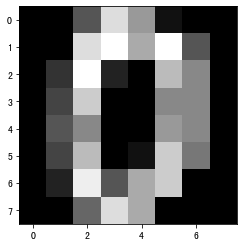

In [2]:
# 查看数据集的情况
digits = datasets.load_digits()
data = digits.data
print(data.shape)  # 数据探索:手写数字数据集一共包括了1797个样本，每幅图像都是8*8像素的矩阵
print(digits.images[0])    # 查看第一幅图像的数据列表
print(digits.target[0])    # 第一幅图像代表的数字含义
plt.gray()     # 显示第一幅图像
plt.imshow(digits.images[0])
plt.show()

vector of image 5:
 [[ 0.  0. 12. 10.  0.  0.  0.  0.]
 [ 0.  0. 14. 16. 16. 14.  0.  0.]
 [ 0.  0. 13. 16. 15. 10.  1.  0.]
 [ 0.  0. 11. 16. 16.  7.  0.  0.]
 [ 0.  0.  0.  4.  7. 16.  7.  0.]
 [ 0.  0.  0.  0.  4. 16.  9.  0.]
 [ 0.  0.  5.  4. 12. 16.  4.  0.]
 [ 0.  0.  9. 16. 16. 10.  0.  0.]]


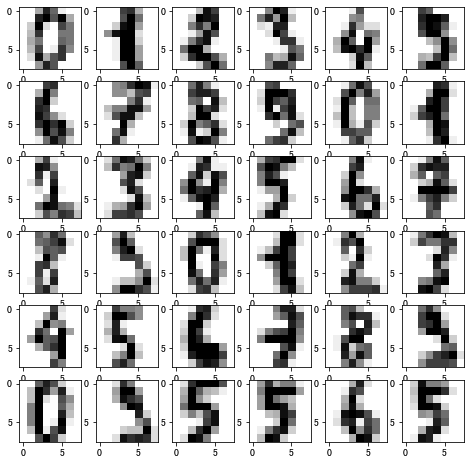

In [3]:
# 编写一个可以看到手写数据集图像的函数
def show_digits():
    digits = datasets.load_digits()    # 加载数据
    fig = plt.figure(figsize=(8,8))
    print(f"vector of image 5:\n", digits.images[5])   # 给出数字5的存储列表
    for i in range(36):
        ax = fig.add_subplot(6, 6, i+1)   # 画出前面36张手写数字的照片
        ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show
    
if __name__ == '__main__':
    show_digits()

/Users/cheneylu/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/cheneylu/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


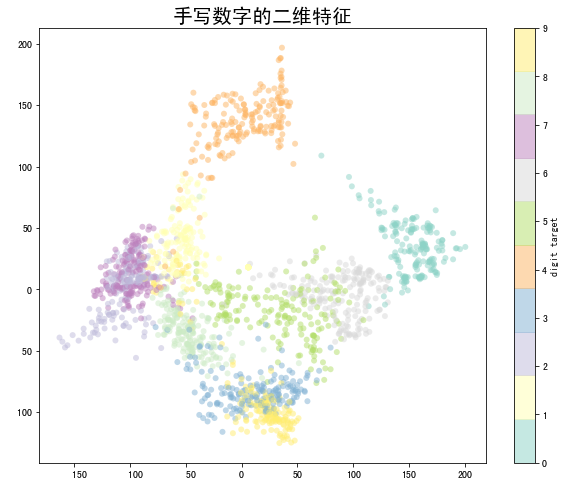

In [4]:
# 把手写数字从高维降低到两维平面上，并进行可视化
feature = Isomap(n_components=2)   # 降成两维
feature.fit(digits.data)
data_projected = feature.transform(digits.data)   # 将数据标准化
fig, ax = plt.subplots(figsize=(10,8))
# 把各个数据点压缩到二维平面上
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target, edgecolor='none', 
            alpha=0.5, cmap=plt.cm.get_cmap('Set3',10))
plt.colorbar(label='digit target', ticks=range(10))  # 设置坐标轴名称
plt.title("手写数字的二维特征", fontsize= 20)     # 设置标题
plt.show()

In [5]:
# 编写载入手写数据集的函数
def manual_digits():
    digits = datasets.load_digits()  # 载入数据集
    X_train = digits.data        # 图像存储的数据信息
    y_train = digits.target      # 图像代表的数字含义
    # 将数据集切分成训练集和测试集，将25%的数据作为测试集
    data = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
    return data

## 3 利用不同的贝叶斯分类方法实现手写数字识别

### 3.1 特征的条件概率分布满足高斯分布

GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian:

In [6]:
# 编写一个高斯分布的朴素贝叶斯分类函数
def GaussianNB_classifier(*digits_data):
    X_train, X_test, y_train, y_test = digits_data
    gnb = naive_bayes.GaussianNB()     # 调用sklearn中的函数进行模型训练
    gnb.fit(X_train, y_train)     # 利用训练集数据进行拟合
    y_pred = gnb.fit(X_train, y_train).predict(X_test)     # 对测试集的数据进行预测
    scores = np.mean(cross_val_score(gnb, X_train, y_train, cv=10))   # 进行十折交叉验证，并求平均得分
    error_num = (y_test != y_pred).sum()        # 统计错误识别个数
    print("Score of GaussianNB on training set:{:.3f}".format(gnb.score(X_train, y_train)))   # 训练集得分
    print("Score of GaussianNB on test set:{:.3f}".format(gnb.score(X_test, y_test)))     # 测试集得分
    print("The cross_val_score is:{:.3f}".format(scores))     # 交叉验证平均得分
    print(f"The number of identification errors is {error_num}")    # 判错个数
    
    # 绘制测试集中真实结果和预测结果的混淆矩阵图
    plt.figure(figsize=(8, 6))
    mat = confusion_matrix(y_test, y_pred)    # 测试集真实值和预测值的混淆矩阵
    sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Set3')    # 用seaborn绘制热力图
    plt.title("Results of GaussianNB method", size=18)
    plt.xlabel('Predicted value', size=15)
    plt.ylabel('True value', size=15)
    plt.show()

### 3.2 特征的条件概率分布满足多项式分布

In [7]:
# 编写一个多项式分布的朴素贝叶斯分类函数
def MultinomialNB_classifier(*digits_data):
    X_train, X_test, y_train, y_test = digits_data
    mnb = naive_bayes.MultinomialNB()     # 调用sklearn中的函数进行模型训练
    mnb.fit(X_train, y_train)     # 利用训练集数据进行拟合
    y_pred = mnb.fit(X_train, y_train).predict(X_test)     # 对测试集的数据进行预测
    scores = np.mean(cross_val_score(mnb, X_train, y_train, cv=10))   # 进行十折交叉验证，并求平均得分
    error_num = (y_test != y_pred).sum()        # 统计错误识别个数
    print("Score of MultinomialNB on training set:{:.3f}".format(mnb.score(X_train, y_train)))  # 训练集得分
    print("Score of MultinomialNB on test set:{:.3f}".format(mnb.score(X_test, y_test)))      # 测试集得分
    print("The cross_val_score is:{:.3f}".format(scores))        # 交叉验证平均得分
    print(f"The number of identification errors is {error_num}")    # 判错个数
    
    # 绘制测试集中真实结果和预测结果的混淆矩阵图
    plt.figure(figsize=(8, 6))
    mat = confusion_matrix(y_test, y_pred)      # 测试集真实值和预测值的混淆矩阵
    sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Pastel1')    # 用seaborn绘制热力图
    plt.title("Results of MultionmialNB method", size=18)
    plt.xlabel('Predicted value', size=15)
    plt.ylabel('True value', size=15)
    plt.show()

### 3.3 特征的条件概率分布满足二项分布

In [8]:
# 编写一个二项分布的朴素贝叶斯分类函数
def BernoulliNB_classifier(*digits_data):
    X_train, X_test, y_train, y_test = digits_data
    bnb = naive_bayes.BernoulliNB()     # 调用sklearn中的函数进行模型训练
    bnb.fit(X_train, y_train)     # 利用训练集数据进行拟合
    y_pred = bnb.fit(X_train, y_train).predict(X_test)     # 对测试集的数据进行预测
    scores = np.mean(cross_val_score(bnb, X_train, y_train, cv=10))   # 进行十折交叉验证，并求平均得分
    error_num = (y_test != y_pred).sum()        # 统计错误识别个数
    print("Score of BernoulliNB on training set:{:.3f}".format(bnb.score(X_train, y_train)))   # 训练集得分
    print("Score of BernoulliNB on test set:{:.3f}".format(bnb.score(X_test, y_test)))     # 测试集得分
    print("The cross_val_score is:{:.3f}".format(scores))     # 交叉验证平均得分
    print(f"The number of identification errors is {error_num}")     # 判错个数
    
    # 绘制测试集中真实结果和预测结果的混淆矩阵图
    plt.figure(figsize=(8, 6))
    mat = confusion_matrix(y_test, y_pred)      # 测试集真实值和预测值的混淆矩阵
    sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='tab20')  # 用seaborn绘制热力图
    plt.title("Results of BernoulliNB method", size=18)
    plt.xlabel('Predicted value', size=15)
    plt.ylabel('True value', size=15)
    plt.show()

Score of GaussianNB on training set:0.847
Score of GaussianNB on test set:0.829
The cross_val_score is:0.826
The number of identification errors is 77


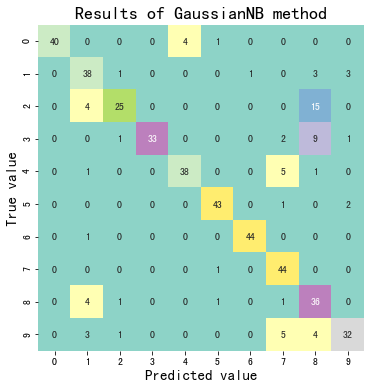

Score of MultinomialNB on training set:0.907
Score of MultinomialNB on test set:0.882
The cross_val_score is:0.900
The number of identification errors is 53


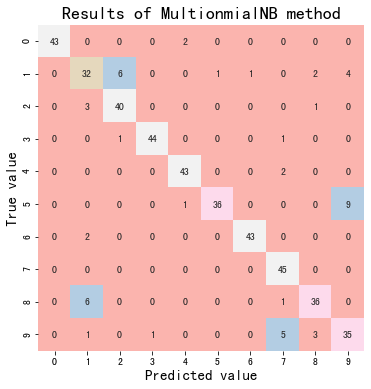

Score of BernoulliNB on training set:0.867
Score of BernoulliNB on test set:0.844
The cross_val_score is:0.857
The number of identification errors is 70


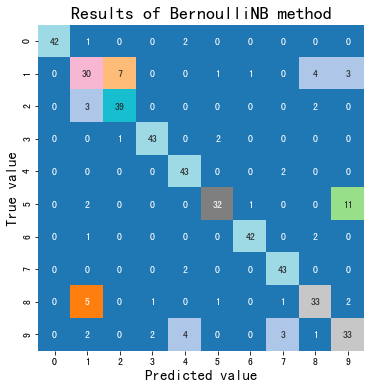

In [9]:
# 调用三种不同方法的函数，并比较三种方法在训练集和测试集上的识别效果
if __name__ == '__main__':
    X_train,X_test,y_train,y_test = manual_digits()
    GaussianNB_classifier(X_train,X_test,y_train,y_test)
    MultinomialNB_classifier(X_train,X_test,y_train,y_test)
    BernoulliNB_classifier(X_train,X_test,y_train,y_test)

### 分析：用三种不同的朴素贝叶斯分类方法识别手写数字，可以得到训练数据和测试数据的识别情况，识别效果用分类得分来衡量，得分表示识别正确的数字个数占总数字的比例。对测试集来说，各种方法的拟合效果得分排名为：多项式朴素贝叶斯分类、二项式朴素贝叶斯分类、高斯分布朴素贝叶斯分类；而对测试集来说，各种方法的拟合效果得分排名为：多项式朴素贝叶斯分类、二项式朴素贝叶斯分类、高斯分布朴素贝叶斯分类；而且交叉验证的得分情况排名情况也是：多项式朴素贝叶斯分类、二项式朴素贝叶斯分类、高斯分布朴素贝叶斯分类。另外MultinomialNB 方法有55个识别错误，而 GaussianNB 有77个识别错误。所以不论是训练集还是测试集，都是MultinomialNB 的方法更好，而 GaussianNB 效果最差。
### 从测试集的混淆矩阵中可以清晰看出识别正确的数字个数以及错判的数字情况，其中MultinomialNB 方法的错判率最低，其中把5错判为9的个数最多，共有9个；GaussianNB 方法的错判率最高，其中有15个2错判为8，9个3被错判为8等等。

### MultinomialNB和BernoulliNB都只有一个参数alpha，用于控制模型复杂度，alpha的工作原理是，算法向数据中添加alpha那么多的虚拟数据点，这些点对所以特征都取正值，这可以将统计数据平滑化。alpha越大，平滑效果越强，模型复杂度就越低，算法性能对alpha的鲁棒性相对较好，即alpha值对模型性能并不是非常重要，但调整这个参数通常会使精度略有提高。GaussianNB主要用于高维数据，而另外两种朴素贝叶斯模型则广泛用于稀疏计数数据，比如文本。一般来说，MultinomialNB的性能通常要优于BernoulliNB，特别是在包含很多非零特征的数据集上。